# Importing the Preliminary Required Libraries

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the Data

In [2]:
df = pd.read_csv("Context.csv")

In [3]:
df.head()

,Text,Context
0,The eternal mystique of Goldman Sachs,Politics
1,Either you don't care enough to actually tell ...,Love
2,I am such an IDIOT.,Heavy Emotion
3,While lifting weights on Friday and doing bent...,Health
4,Something's watching me,Animals


In [4]:
len(df.Context.value_counts())

11

In [5]:
df.Context.unique()

array(['Politics', 'Love', 'Heavy Emotion', 'Health', 'Animals',
       'Science', 'Joke', 'Compliment', 'Religion', 'Self', 'Education'],
      dtype=object)

# Data Visualization (Preliminary)

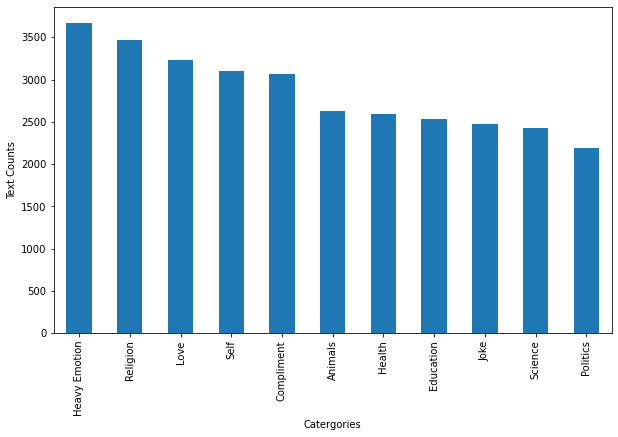

In [6]:
Context = ['Politics','Love','Heavy Emotion','Health','Animals','Science','Joke','Compliment','Religion','Self','Education']
plt.figure(figsize=(10,6))
plt.ylabel('Text Counts')
plt.xlabel('Catergories')
df.Context.value_counts().plot(kind='bar');

# Checking for NULLs and removing them

In [7]:
df.isnull().sum()

Text       0
Context    0
dtype: int64

# Dropping duplicates

In [8]:
df.shape

(31386, 2)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(31321, 2)

# Preprocessing the text

In [11]:
print(df['Text'].apply(lambda x: len(x.split(' '))).sum())

768377


# Cleaning the Text

In [12]:
special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [13]:
def clean_text(text):
    text = text.lower()
    text = special_character_remover.sub(' ', text)
    text = extra_symbol_remover.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
    
df['Text'] = df['Text'].apply(clean_text)

In [14]:
print(df['Text'].apply(lambda x: len(x.split(' '))).sum())

405694


# Train Test split

In [15]:
%time from sklearn.model_selection import train_test_split
X = df.Text
y = df.Context
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

Wall time: 0 ns


In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21924,), (9397,), (21924,), (9397,))

# Method1 :Applying Naive Bayes Classifier

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

naivebayes = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
naivebayes.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

Predicting the Test set 

In [18]:
%time y_pred = naivebayes.predict(X_test)

Wall time: 134 ms


Making the Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[451  20   6  11 143  17  78   8  13  22  29]
 [  0 559   6   7 229  12  75   2  22   4  16]
 [  7  12 396   6 216   5  44   5  48  14  31]
 [  9  12  25 393 179   8  53   6  28  65  31]
 [  5  19   4   6 902   8 134   4  13   2  21]
 [  8  14   3   4 212 341  79   3  23   2  24]
 [  5  21   2   1 266   9 569   0  26   2  17]
 [  3   6   9   8  78   8  14 442  39   9  20]
 [  6  29  10   5 164   8  62  13 715  11  32]
 [ 25  18  31  73  98   6  44  12  66 308  41]
 [ 11  14  24  15 303  15  71   4  33   5 417]]


0.5845482600830052

Cross Validation

In [20]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = naivebayes,X = X_train, y = y_train, cv =10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 58.13 %
Standard Deviation: 1.05 %


# Method 2: Linear support vector machine

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

Predicting the Test set

In [22]:
%time y_pred = sgd.predict(X_test)

Wall time: 419 ms


Making the Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[552  34   8  15  27  22  38  17  30  29  26]
 [ 12 648  19  15  54  24  48   8  54  10  40]
 [ 24  28 525  14  28  12  23  19  57  17  37]
 [ 26  25  42 475  24  20  29  20  46  76  26]
 [ 28  84  41  26 555  52 150  26  70  11  75]
 [ 28  43  15  16  31 446  40  16  35   7  36]
 [ 26  64  22  13 117  35 525   4  53  16  43]
 [  7  10  21  26   6  19   5 494  27  14   7]
 [ 25  45  21  13  33  21  37  22 770  26  42]
 [ 57  24  50  88  10  11  16  27  59 357  23]
 [ 32  49  57  30  80  43  55  24  49  19 474]]


0.6194530169202938

Cross Validation

In [24]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = sgd,X = X_train, y = y_train, cv =10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 61.69 %
Standard Deviation: 1.12 %


# Final Prediction of test set (Best Model)

In [25]:
%%time

y_pred = sgd.predict(X_test)

print('Accuracy: %s' % accuracy_score(y_pred, y_test))


Accuracy: 0.6194530169202938
Wall time: 408 ms


# Classification Report

In [26]:
print(classification_report(y_test, y_pred,target_names=Context))

               precision    recall  f1-score   support

     Politics       0.68      0.69      0.68       798
         Love       0.61      0.70      0.65       932
Heavy Emotion       0.64      0.67      0.65       784
       Health       0.65      0.59      0.62       809
      Animals       0.58      0.50      0.53      1118
      Science       0.63      0.63      0.63       713
         Joke       0.54      0.57      0.56       918
   Compliment       0.73      0.78      0.75       636
     Religion       0.62      0.73      0.67      1055
         Self       0.61      0.49      0.55       722
    Education       0.57      0.52      0.54       912

     accuracy                           0.62      9397
    macro avg       0.62      0.62      0.62      9397
 weighted avg       0.62      0.62      0.62      9397



# Pickling the model

In [27]:
import pickle

In [28]:
pickle_file = open('sgd.pkl', 'ab')

In [29]:
pickle.dump(sgd, pickle_file)

In [30]:
pickle_file.close()